/home/user/repos/finetuning
torch.Size([32, 32])


/tmp/ipykernel_3717637/3747147109.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value_fetcher_pt = torch.load("experiment_1/results/path_patching/llama_circuit/value_f

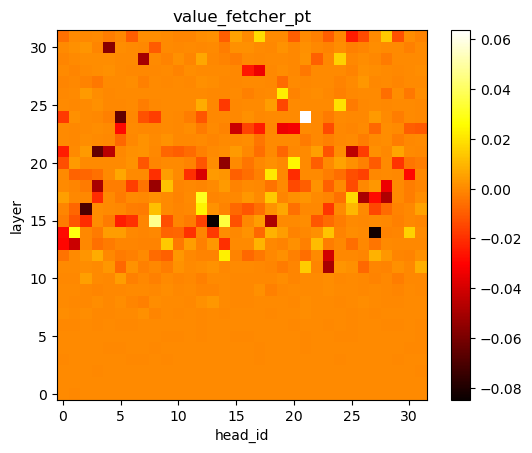

In [1]:
# open the pt file that was saved under "experiment_1/results/path_patching/llama_circuit/value_fetcher.pt" with torch.save and print

import torch
import os
import matplotlib.pyplot as plt
print(os.getcwd())

value_fetcher_pt = torch.load("experiment_1/results/path_patching/llama_circuit/value_fetcher.pt").to("cpu")
print(value_fetcher_pt.shape)

# plot the value_fetcher_pt as a heatmap to visualize the values
plt.imshow(value_fetcher_pt, cmap='hot', interpolation='nearest')
# the rows are the layers of an llm, the columns are the head_ids. label the axes and the title of the plot
plt.xlabel("head_id")
plt.ylabel("layer")
plt.title("value_fetcher_pt")
# y axis should start from 0 at the bottom
plt.gca().invert_yaxis()
# add a colorbar to the plot
plt.colorbar()
plt.show()

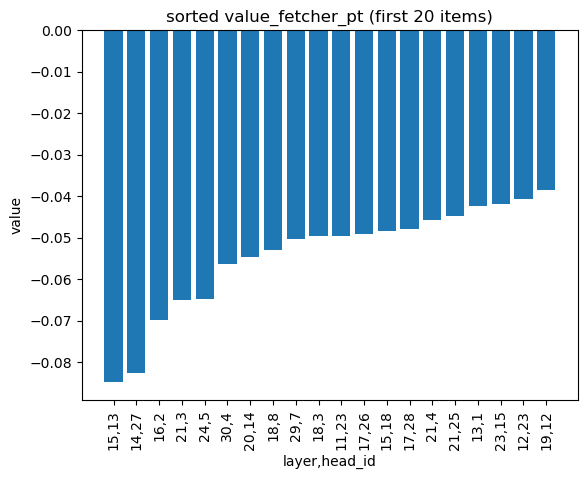

In [2]:
# sort the values in ascending order
sorted_values, sorted_indices = torch.sort(value_fetcher_pt.flatten(), descending=False)
# get the layer and head indices from the sorted indices
layer_indices = sorted_indices // value_fetcher_pt.shape[1]
head_indices = sorted_indices % value_fetcher_pt.shape[1]
# plot the first 20 sorted values
plt.bar(range(20), sorted_values[:20])
# label the x axis with the layer and head indices
plt.xticks(range(20), [f"{layer_indices[i].item()},{head_indices[i].item()}" for i in range(20)], rotation=90)
plt.xlabel("layer,head_id")
plt.ylabel("value")
plt.title("sorted value_fetcher_pt (first 20 items)")
plt.show()


# Let's visualise the places where Llama-1, Goat, FLoat and Llama-3 have circuits

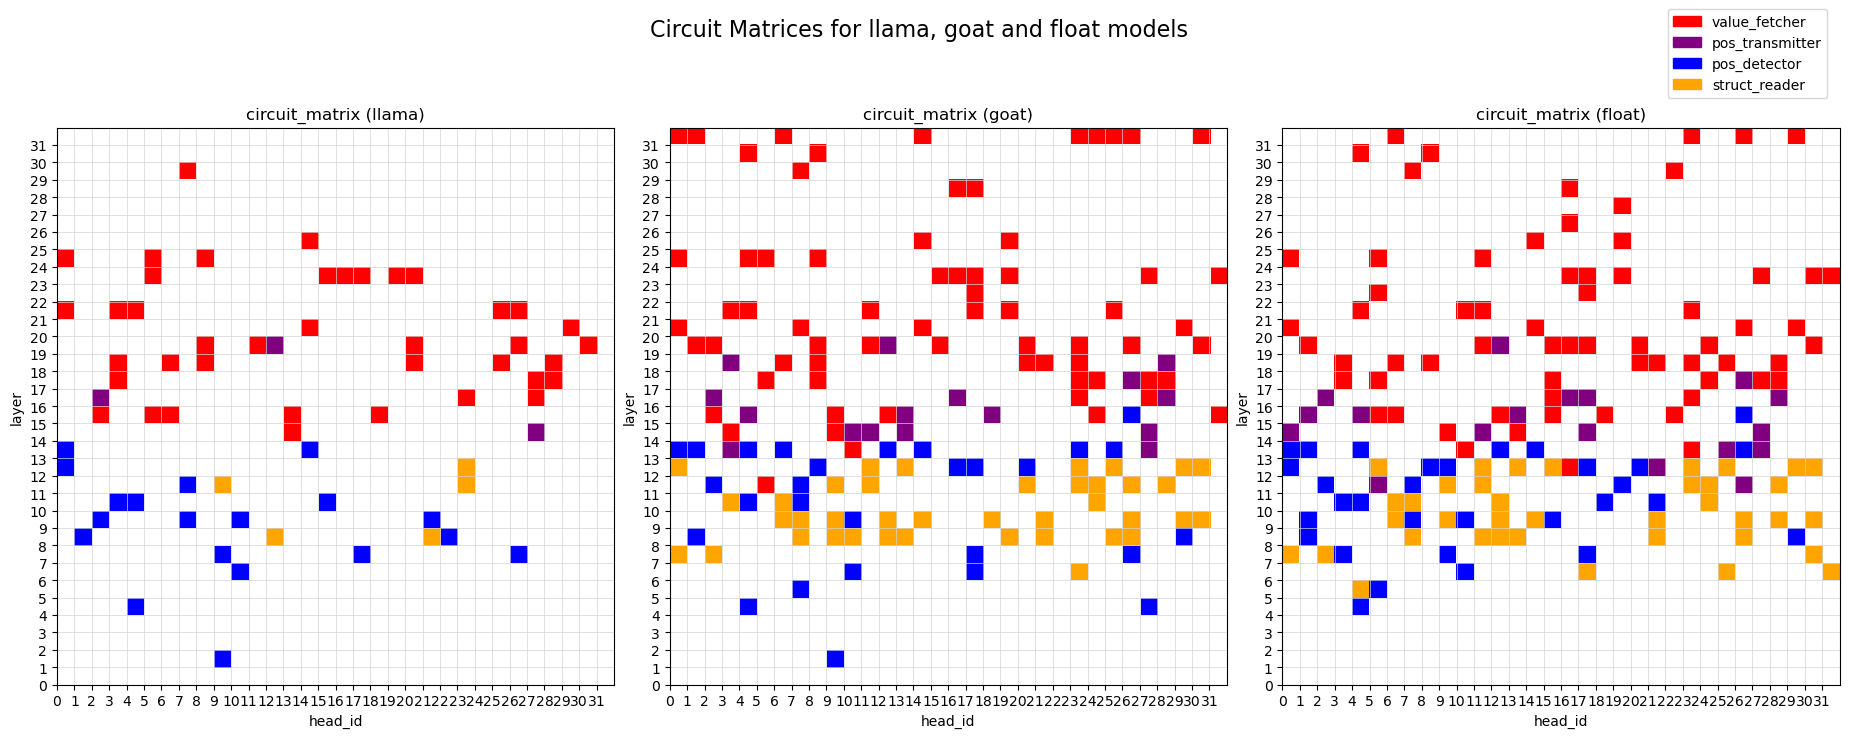

In [3]:
import json
import matplotlib.colors as mcolors

def visualise_circuit(model_name, ax):
    with open("experiment_1/results/circuits/" + model_name + "_circuit.json") as f:
        data = json.load(f)
    
    value_fetcher = data["value_fetcher"]
    pos_transmitter = data["pos_transmitter"]
    pos_detector = data["pos_detector"]
    struct_reader = data["struct_reader"]
    
    colours = ["white", "red", "purple", "blue", "orange"]
    
    circuit_matrix = torch.zeros_like(value_fetcher_pt)
    for component, colour in zip([value_fetcher, pos_transmitter, pos_detector, struct_reader], colours[1:]):
        for layer, head_id in component:
            circuit_matrix[layer, head_id] = colours.index(colour)
    
    cmap = mcolors.ListedColormap(colours)
    
    ax.imshow(circuit_matrix, cmap=cmap, extent=[0, value_fetcher_pt.shape[1], value_fetcher_pt.shape[0], 0])
    ax.set_xlabel("head_id")
    ax.set_ylabel("layer")
    ax.set_title(f"circuit_matrix ({model_name})")
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.set_xticks(range(0, value_fetcher_pt.shape[1], 1))
    ax.set_yticks(range(0, value_fetcher_pt.shape[0], 1))
    # now flip y axis
    ax.invert_yaxis()

fig, axs = plt.subplots(1, 3, figsize=(23, 8))
fig.subplots_adjust(wspace=0.1)  # Adjust the space between subplots

visualise_circuit("llama", axs[0])
visualise_circuit("goat", axs[1])
visualise_circuit("float", axs[2])

# add plot title
fig.suptitle("Circuit Matrices for llama, goat and float models", fontsize=16)


# Add a single legend for both subplots
colours = ["white", "red", "purple", "blue", "orange"]
fig.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colour) for colour in colours[1:]], 
           labels=["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"], 
           loc="upper center", bbox_to_anchor=(0.86, 1.0), ncol=1)

plt.show()

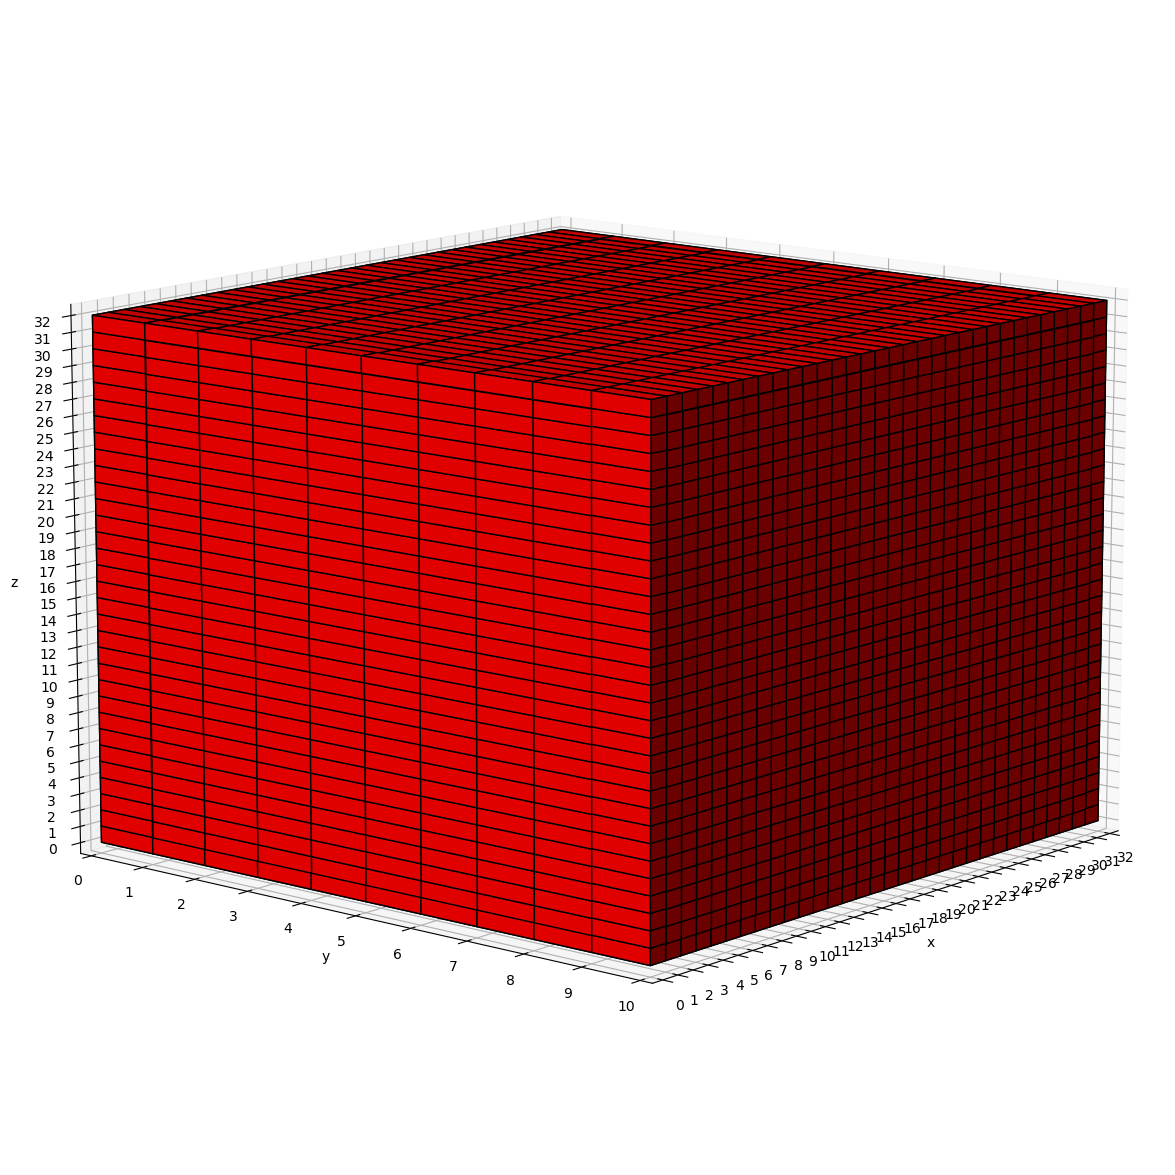

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define cube dimensions
x_size, y_size, z_size = 32, 10, 32

# Create a 3D boolean grid
cube = np.ones((x_size, y_size, z_size), dtype=bool)

# Create figure and axis
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor('white')

# Use ax.voxels with the correct shape
ax.voxels(cube, facecolors='red', edgecolor='k')

# Set exact axis limits
ax.set_xlim(0, x_size)
ax.set_ylim(0, y_size)
ax.set_zlim(0, z_size)

# Set ticks exactly at the integer positions
ax.set_xticks(np.arange(0, x_size + 1, 1))
ax.set_yticks(np.arange(0, y_size + 1, 1))
ax.set_zticks(np.arange(0, z_size + 1, 1))

# Invert x-axis for better perspective
ax.invert_xaxis()

# Adjust the view angle
ax.view_init(elev=12, azim=40)

plt.show()



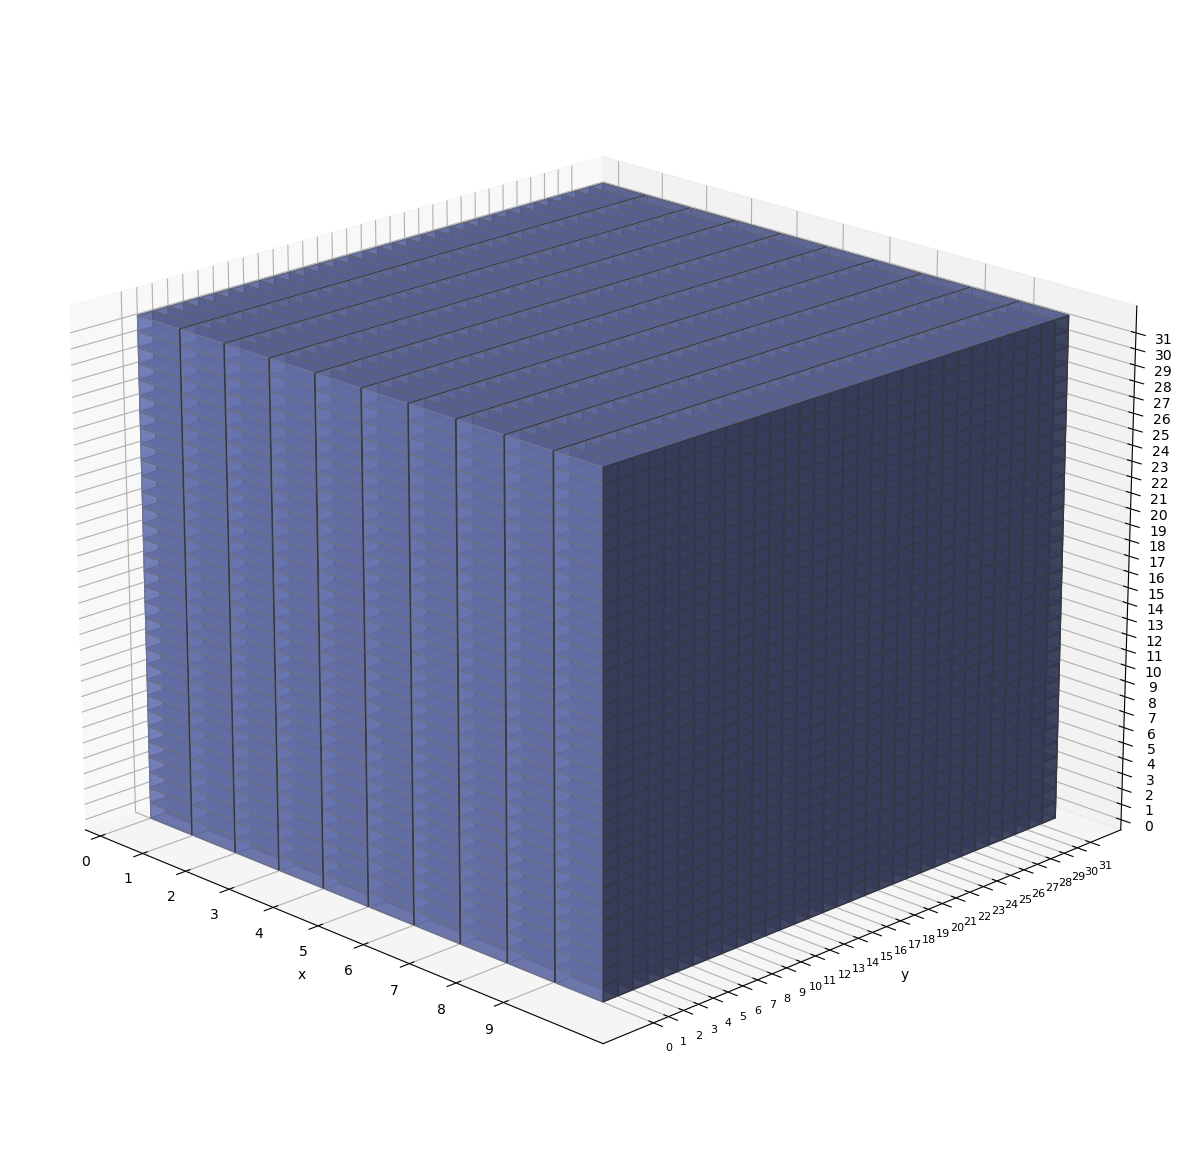

In [29]:
import matplotlib.pyplot as plt
import numpy as np


def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# axes sizes
x_dim = 10
y_dim = 32
z_dim = 32
n_voxels = np.zeros((x_dim, y_dim, z_dim), dtype=bool)
# n_voxels[0, 0, :] = True
# n_voxels[-1, 0, :] = True
# n_voxels[1, 0, 2] = True
# n_voxels[2, 0, 1] = True
facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
filled = np.ones(n_voxels.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.02
y[:, 0::2, :] += 0.02
z[:, :, 0::2] += 0.02
x[1::2, :, :] += 0.98
y[:, 1::2, :] += 0.98
z[:, :, 1::2] += 0.98


fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(projection='3d')

ax.voxels(x + 0.35, y - 1, z + 0.1, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# ax.set_xlim(0, x_dim)
# ax.set_ylim(0, y_dim)
ax.set_zlim(0, z_dim)

ax.set_xticks(np.arange(0, x_dim, 1))
ax.set_yticks(np.arange(0, y_dim, 1))
ax.set_zticks(np.arange(0, z_dim, 1))
plt.yticks(fontsize=8)


# ax.set_aspect('equal')
ax.view_init(elev=20, azim=-45)

plt.show()